In [1]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class DataLoader:
    def __init__(self):
        self.train, self.valid, self.test = self.load_data()

    def load_data(self):
        """Load MNIST train, validation, and test data."""
        # For notebooks, use relative path to parent directory
        data_path = '../mnist.pkl'
        with open(data_path, 'rb') as f:
            train, valid, test = pickle.load(f, encoding='latin-1')
        return train, valid, test
    
    def get_data_information(self):
        """Return the shape of the datasets, their data types, unique labels and data range."""
        return {
            'train': (self.train[0].shape, self.train[1].shape),
            'train_data_type': type(self.train[0]),
            'valid': (self.valid[0].shape, self.valid[1].shape),
            'valid_data_type': type(self.valid[0]),
            'test': (self.test[0].shape, self.test[1].shape),
            'test_data_type': type(self.test[0]),
            'unique_labels': set(self.train[1]),
            'training_data_range': (self.train[0].min(), self.train[0].max())
        }
    
    def get_train_data(self):
        """Return training data and labels."""
        return self.train

    def get_valid_data(self):
        """Return validation data and labels."""
        return self.valid

    def get_test_data(self):
        """Return test data and labels."""
        return self.test
    
    def get_all_data(self):
        """Return all datasets."""
        return self.train, self.valid, self.test
    
    def print_data_summary(self):
        """Print a summary of the datasets."""
        info = self.get_data_information()
        print("Data Summary:")
        print(f"Training set: {info['train'][0]} samples, Labels: {info['train'][1]}")
        print(f"Validation set: {info['valid'][0]} samples, Labels: {info['valid'][1]}")
        print(f"Test set: {info['test'][0]} samples, Labels: {info['test'][1]}")
        print(f"Unique labels in training set: {info['unique_labels']}")
        print(f"Training data range: {info['training_data_range']}")
    
    def draw_sample(self, data, labels, index=None):
        """Draw a sample image from the dataset.
        
        Args:
            data: Image data array (samples, height, width) or (samples, pixels)
            labels: Label array
            index: Index of image to draw (random if None)
        """
        if index is None:
            index = np.random.randint(0, len(data))
        
        image = data[index]
        label = labels[index]
        
        # Reshape if flattened (784 pixels -> 28x28)
        if len(image.shape) == 1:
            image = image.reshape(28, 28)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

# Data example

Data Summary:
Training set: (50000, 784) samples, Labels: (50000,)
Validation set: (10000, 784) samples, Labels: (10000,)
Test set: (10000, 784) samples, Labels: (10000,)
Unique labels in training set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Training data range: (0.0, 0.99609375)


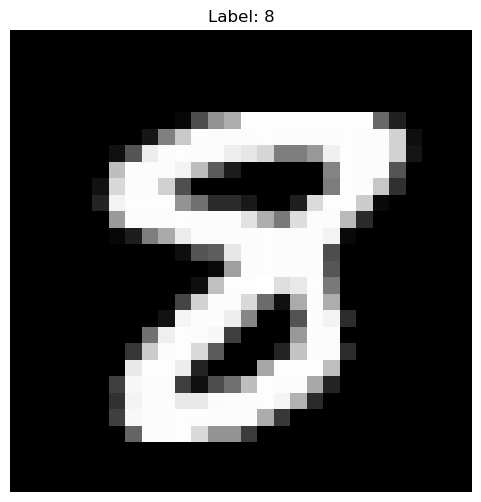

In [3]:
# Test the DataLoader
loader = DataLoader()
loader.print_data_summary()
train_data, train_labels = loader.get_train_data()
loader.draw_sample(train_data, train_labels)

In [26]:
class Data:
    """Data class for implementing autograd for np.ndarray operations. Defines all operations that np.ndarray does (hopefully)."""

    def __init__(self, values: np.ndarray, parents=None, grad=False):
        """init
        Args:
            values: np.array of data values
            parents: object parents, default=None
            save_grad: whether to update values during SGD. Shold be set to True for weights and biases. default=False
        """
        self._data = values
        self._backward = lambda:None
        self._grad = grad 
        self._num_grad = None  # numerical gradient calc. during backprop
        self._parents = parents

    def __str__(self):
        return str(self._data)

    def __repr__(self):
        return f"grad={self._grad} data={str(self)}"

    def __add__(self, other):
        if isinstance(other, Data):
            out = Data(
                self._data + other._data,
                parents=(self, other)
            )

            def _backward():
                self._num_grad = out._num_grad
                other._num_grad = out._num_grad

            out._backward = _backward
            return out

        try:
            out = Data(self._data + other, parents=(self,))

            def _backward():
                self._num_grad = out._num_grad

            out._backward = _backward
            return out
        except:
            raise TypeError("bruh")

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if isinstance(other, Data):
            out = Data(
                self._data - other._data,
                parents=(self, other)
            )

            def _backward():
                self._num_grad = out._num_grad
                other._num_grad = -out._num_grad

            out._backward = _backward
            return out

        try:
            out = Data(self._data - other, parents=(self,))

            def _backward():
                self._num_grad = out._num_grad

            out._backward = _backward
            return out
        except:
            raise TypeError("bruh")

    def __rsub__(self, other):
        return -self + other

    def __mul__(self, other):
        if isinstance(other, Data):
            out = Data(
                self._data * other._data,
                parents=(self, other)
            )

            def _backward():
                self._num_grad = out._num_grad * other._data
                other._num_grad = out._num_grad * self._data

            out._backward = _backward
            return out
        try:
            out = Data(self._data * other, parents=(self,))

            def _backward():
                self._num_grad = out._num_grad * other

            out._backward = _backward
            return out
        except:
            raise TypeError("bruh")

    def __rmul__(self, other):
        return self * other

    def __matmul__(self, other):
        if isinstance(other, Data):
            out = Data(
                self._data @ other._data,
                parents=(self, other)
            )
            def _backward():
                self._num_grad=out._num_grad@other._data.T
                other._num_grad=self._data.T@out._num_grad #s/o to gpt for this one
            out._backward=_backward
            return out

        try:
            out= Data(self._data @ other, parents=(self,))
            def _backward():
                self._num_grad=out._num_grad@other.T
            out._backward=_backward
            return out
        except:
            raise TypeError("bruh")

    # def __rmatmul__(self, other): #this is wrong but that is fine
    #     return self @ other

    def __truediv__(self, other):
        if isinstance(other, Data):
            out= Data(
                self._data / other._data,
                parents=(self, other)
            )
            def _backward():
                self._num_grad=out._num_grad/other._data
                other._num_grad = out._num_grad * (-self._data / (other._data ** 2))
            out._backward=_backward
            return out
        try:
            out= Data(self._data / other, parents=(self,))
            def _backward():
                self._num_grad=out._num_grad/other
            return out
        except:
            raise TypeError("bruh")

    def __rtruediv__(self, other):
        return other * Data(np.array([1.0])) / self

    def __neg__(self):
        out= Data(-self._data, parents=(self,))
        def _backward():
            self._num_grad=out._num_grad
        out._backward=_backward
        return out
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise TypeError("BRUHHH")
        out=Data(self._data**other, parents=(self, ))
        def _backward():
            self._num_grad=out._num_grad*other*self._data**(other-1)
        out._backward=_backward
        return out

    def exp(self):
        out= Data(np.exp(self._data), parents=(self,))
        def _backward():
            self._num_grad=np.exp(self._data)*out._num_grad
        out._backward=_backward
        return out
    def sigmoid(self):
        out=Data(1/(1+np.exp(self._data)), parents=(self, ))
        def _backward():
            self._num_grad=out._num_grad*(out._data*(1-out._data)) #see definition
        out._backward=_backward
        return out

    def backward(self):
        self._nodes = []
        visited = set()

        def sort(item):  # topological sorting
            if not item in visited:
                visited.add(item)
            if not item._parents:
                pass
            else:
                for parent in item._parents:
                    sort(parent)
            self._nodes.append(item)

        sort(self)
        self._num_grad = np.ones_like(self._data, dtype=np.float64)
        for item in reversed(self._nodes):
            item._backward()
        return None
    def step(self,step_size):
        for item in reversed(self._nodes):
            if item._grad:
                if item._data.shape[1]==1:
                    item._data-=step_size*np.mean(item._num_grad, axis=1).reshape(item._data.shape)
                else:
                    item._data-=step_size*item._num_grad


class Layer:
    def __init__(self, input: int, output: int, a_function):
        self._weights = Data(np.random.normal(loc=0, scale=1.0, size=(output, input)), grad=True)
        self._bias = Data(np.random.normal(loc=0, scale=0, size=(output, 1)), grad=True)
        self._activation = a_function

    def forward(self, input: np.ndarray):
        a = self._weights @ input + self._bias
        if self._activation=="sigmoid":
            o=a.sigmoid()
        else:
            o = self._activation(a)
        return o

    def __str__(self):
        return f"Layer of {len(self._weights)} neurons"


class NeuralNetwork:
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list,
        output_size: int,
        activation_function,
        final_activation=True,
    ):
        if not isinstance(activation_function, list):
            activation_function = [
                activation_function for _ in range(len(hidden_sizes) + 2)
            ]
        sizes = [input_size] + hidden_sizes + [output_size]
        self._layers = []
        for i in range(len(sizes)-1):
            self._layers.append(Layer(sizes[i], sizes[i + 1], activation_function[i]))

    def forward(self, x):
        z = x
        for layer in self._layers:
            z=layer.forward(z)
        return z
        # """
        # X: input with shape (input_size, batch_size) ← mini-batch
        # Output: y_hat with shape (output_size, batch_size)
        # """
        # # 1) Add bias neuron to input layer: (input_size+1, batch_size)
        # Xb = self._append_bias_row(X)

        # # 2) Pre-activation of hidden layer: z1 = W1 · Xb
        # z1 = self.W1 @ Xb

        # # 3) Hidden layer activation: a1 = sigmoid(z1) → (hidden_size, batch_size)
        # a1 = self.sigmoid(z1)

        # # 4) Add bias neuron to a1: (hidden_size+1, batch_size)
        # a1b = self._append_bias_row(a1)

        # # 5) Pre-activation of output layer: z2 = W2 · a1b
        # z2 = self.W2 @ a1b

        # # 6) Output activation: a2 = sigmoid(z2) → (output_size, batch_size)
        # a2 = self.sigmoid(z2)

        # # Save for backpropagation
        # self.cache = {
        #     "X": X, "Xb": Xb,
        #     "z1": z1, "a1": a1, "a1b": a1b,
        #     "z2": z2, "a2": a2
        # }
        # return a2

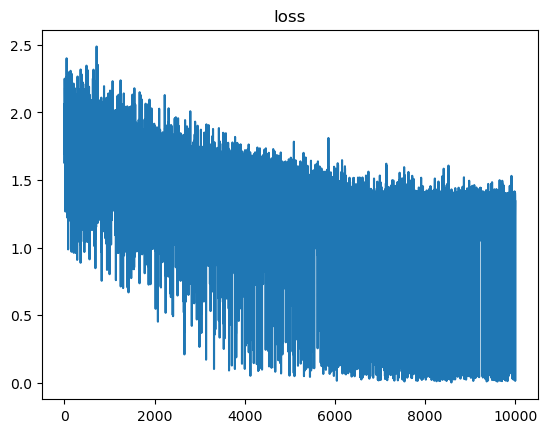

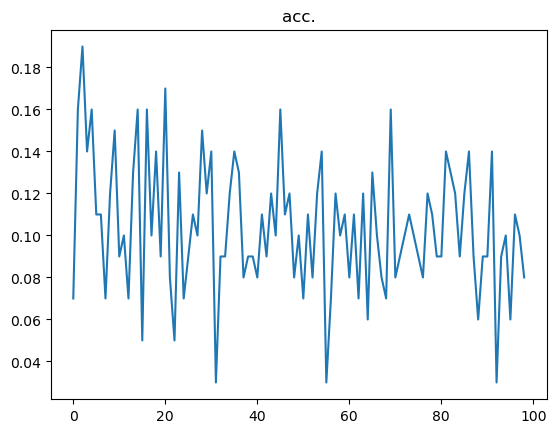

In [24]:
data=loader.get_train_data()
model=NeuralNetwork(784, [30, 30], 10, "sigmoid")
loss=[]
loops=10000
guess=[]
for i in range(loops):
    datapoint=np.random.randint(0, 50000)
    x=data[0][datapoint].reshape((784,1 ))
    y=model.forward(x)
    correct=np.zeros((10, 1));correct[data[1][datapoint]]=1
    guess.append(np.argmax(y._data)==data[1][datapoint])
    L=(y-correct)**2
    loss.append(np.linalg.norm(L._data)) #for plotting
    L.backward()
    L.step(-0.001)
plt.plot([i for i in range(loops)], loss)
plt.title("loss")
plt.show()
acc=[]
for i in range(0, loops-100, 100):
    acc.append(np.sum(guess[i:i+100])/100)
plt.plot([i for i in range(len(acc))], acc)
plt.title("acc.")
plt.show()
    


bias:
(10, 1)
(10, 120)
bias:
(10, 1)
(10, 120)
bias:
(10, 1)
(10, 120)
weights:
(10, 784)
(10, 784)
weights:
(10, 10)
(10, 10)
weights:
(10, 10)
(10, 10)
bias:
(10, 1)
(10, 120)
bias:
(10, 1)
(10, 120)
bias:
(10, 1)
(10, 120)
weights:
(10, 784)
(10, 784)
weights:
(10, 10)
(10, 10)
weights:
(10, 10)
(10, 10)


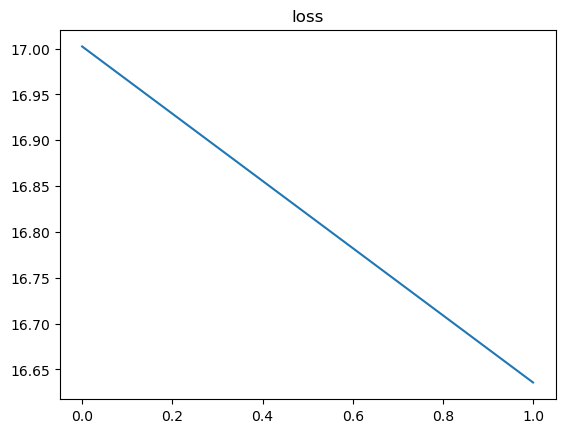

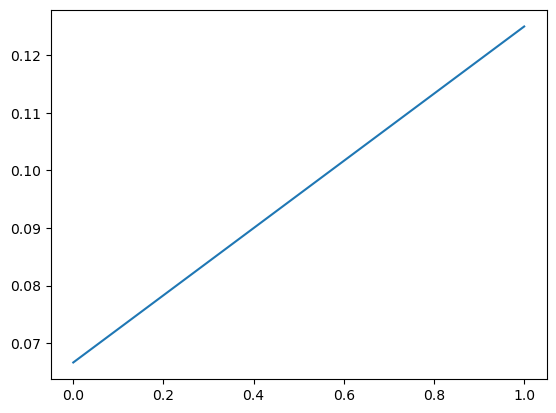

In [28]:
data=loader.get_train_data()
model=NeuralNetwork(784, [10, 10], 10, "sigmoid")
loss=[]
batches=2
batch_size=120
acc=[]
for i in range(batches):
    correct=0
    rand=np.random.randint(0, 50000-batch_size)
    x=data[0][rand:rand+batch_size, :].reshape((784,batch_size ))
    labels=data[1][rand:rand+batch_size]
    y=model.forward(x)
    y_corr=np.zeros((10, batch_size))
    for i in range(batch_size):
        correct_label=labels[i]
        y_corr[correct_label, i]=1
        if np.argmax(y._data[:, i])==labels[i]: #for plotting accuracy
            correct+=1
    L=(y-y_corr)**2
    loss.append(np.linalg.norm(L._data)) #for plotting loss
    L.backward()
    L.step(-0.001)
    acc.append(correct/batch_size)
plt.plot([i for i in range(batches)], loss)
plt.title("loss")
plt.show()
plt.plot(acc)
plt.show()

## Test

In [9]:
input_size, hidden_size, output_size = 784, 30, 10
B = 16  # batch size
def sigmoid(x):
    return 1/(1+np.exp(-x))
nn = NeuralNetwork(784, [30], 10, sigmoid)  # ← مقیاس خارج از منابع
print(type(nn.forward(np.random.rand(784, 1))))
print(nn.forward(np.random.rand(784, 10))) #seems to work



<class '__main__.Data'>
[[7.54731920e-03 4.23286965e-03 4.66509724e-02 8.71407267e-02
  3.46454398e-03 7.54601333e-02 1.10316874e-01 5.05002943e-02
  2.74309388e-02 1.98161547e-02]
 [9.78075252e-01 9.97449651e-01 9.94430544e-01 8.69264148e-01
  9.98485945e-01 9.33797697e-01 8.59267408e-01 9.94589876e-01
  9.83546874e-01 8.49502564e-01]
 [7.04441956e-01 2.86380816e-01 3.95972170e-01 8.18584354e-01
  2.76181291e-01 9.20699816e-01 8.61819816e-01 9.47704570e-01
  3.06273232e-01 6.39377250e-01]
 [1.40202490e-02 1.93160020e-02 1.87062620e-02 1.94797401e-01
  5.44026643e-02 2.03462784e-01 6.89804025e-02 1.56940563e-02
  1.23714844e-02 2.39884852e-01]
 [9.28058186e-03 1.14985534e-02 6.23401231e-04 6.55568119e-03
  8.77364762e-03 7.95528277e-02 1.93375755e-02 9.15787705e-04
  9.02185027e-03 7.68037622e-03]
 [9.87240715e-01 9.87514122e-01 9.78291259e-01 3.80268366e-01
  9.77664901e-01 9.85047482e-01 9.63747929e-01 9.63766580e-01
  9.74501947e-01 9.76583370e-01]
 [6.59290817e-01 1.66533731e-01 1.